# The Machine Learning Workflow Annotated

Source: [Pytorch / Learn the Basics](https://pytorch.org/tutorials/beginner/basics/intro.html)

```{attention} TODO

- Store a properly parametrized model in the repo and USE it (inference) before creating your own.
- Simplify model archi, get rid of sequential
- Explain logit stuff & give math formulas
- Explain & test cross-entropy
- Show that the neural network accepts batched data
- Implement the "PIL image to category -> proba sorted mapping" as task.
- Plot ReLU graph
- Clean up the use of logits; here it actually refers to log-probabilites
- Annotate & tweak learning
```

In [1]:
import torch
import torchvision

## The FashionMNIST Dataset 

In [2]:
# Download training data from open datasets.
training_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)

# Download test data from open datasets.
test_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)

In [3]:
data = torchvision.datasets.FashionMNIST(root="data") # by default: training data set, no input/output transform, no download
data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train

In [4]:
# data is list-like ; each item in an input-output pair
datum = data[0]
datum

(<PIL.Image.Image image mode=L size=28x28>, 9)

In [5]:
image, index = datum

In [6]:
image

In [7]:
# The output is a number that denotes the class of the pictured object. The list of categories is:
print(data.classes)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [8]:
# Get the category name from the index:
data.classes[index] # that checks out!

'Ankle boot'

In [9]:
import pandas as pd
df = [{"image": image, "category": data.classes[index]} for image, index in data]
df = pd.DataFrame(df)
df

,image,category
0,<PIL.Image.Image image mode=L size=28x28 at 0x...,Ankle boot
1,<PIL.Image.Image image mode=L size=28x28 at 0x...,T-shirt/top
2,<PIL.Image.Image image mode=L size=28x28 at 0x...,T-shirt/top
3,<PIL.Image.Image image mode=L size=28x28 at 0x...,Dress
4,<PIL.Image.Image image mode=L size=28x28 at 0x...,T-shirt/top
...,...,...
59995,<PIL.Image.Image image mode=L size=28x28 at 0x...,Sandal
59996,<PIL.Image.Image image mode=L size=28x28 at 0x...,Trouser
59997,<PIL.Image.Image image mode=L size=28x28 at 0x...,Dress
59998,<PIL.Image.Image image mode=L size=28x28 at 0x...,T-shirt/top


In [10]:
import base64
import io
from IPython.display import HTML

def image_formatter(image):
    with io.BytesIO() as buffer:
        image.save(buffer, "jpeg")
        _bytes = buffer.getvalue()
    _base64 = base64.b64encode(_bytes).decode("ascii")
    return f'<img src="data:image/jpeg;base64, {_base64}">'

HTML(df.head().to_html(formatters={'image': image_formatter}, escape=False))

,image,category
0,"<img src=""data:image/jpeg;base64, /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/wAALCAAcABwBAREA/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/9oACAEBAAA/APn+tbw1oNx4m8QWmkWx2yXD4LkZCADJJ+gFbviL4a63oc7COE3MW4hdn38duD976jNc9daDqllIsc9lKrMu4YGeMkdR7gj8KzcV7H8BtEvV16+1iWCeG1Wz8mOV02pIzupwCeuAp6Z98cZ90aIzLIlw0c0ZJ4KgjHoeOa+evjS9n/wnMcNxBPCYLKONFhA2FNzMpGenDcgd816V4K03wefC+m3NlpVhP+5QSXBiR5fMx825iMg5zwce3FdbOzTwgW90lu6uCm8eYrL02soIyCPQgggEdMGQ3cluiPNK0rJwrRQBNueuMkt+teNfGKxsdY8WWdxNqcNo66eieXMwVsb5DnH415Hp2rajpE5n02/urOUjBe3laMkehIPIrVm8eeLrhNknibVivoLtx/I1UPinxC3XXtUP1vJP8ay5JZJpGkldnduSzHJP41//2Q=="">",Ankle boot
1,"<img src=""data:image/jpeg;base64, /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/wAALCAAcABwBAREA/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/9oACAEBAAA/AOB+E3gyz8V6xez6lE01jYRqWiDFQ8jk7QSOcYVjxjoK9hlufDultLpcPhSa5itZdjra6NFNCshiEh5Yj5tmCTTjpvhnxg9zYX/huSCe3SMyLeWC20yI+7aUZTnb8jcA446V81a7pcmh69qGlytue0uHh3f3gpIB/Ec/jXSeBfiJf+CvMt7ezsp7a4lV5vORg/HHDKR2z1z1NfQF94U8Oapez3l7o9vczzkGSSR5MvjAGcMB0C9B2rC8Uz2Xw28LXGp+HdIsoJ5JIoCr+YyNyx5y2eMtjBHJr5517WrrxFrdzq16sS3FwwLiJdqjAAGB9AKzq+zkXjAAGcnivP8A4zLu8ATf7N1C/wCrD+tfONFfUf8AwlV5AmBbWrbQACwf0Ho1cV8S/Edzqfg66t5be2RTLFzGHzw2e7GvEa//2Q=="">",T-shirt/top
2,"<img src=""data:image/jpeg;base64, /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/wAALCAAcABwBAREA/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/9oACAEBAAA/APn+vX/DGqaVa6HZw6r4X07VQIFMLyxqrpkZIJ2/MM5P4nrXH+PZUuLu0njs7a0VlcLDbRBERQRhRgc49fc1yFFenaeANMsx6QRj/wAdFc/41H7uwOOcyc+3yf8A165GivUbVSlnAh6rEgP/AHyKwPGa7rK0fH3JGHX1A/wrjaK6zRPEN5Ni2mWKQImA7Kdxx6kGsfWdXudSmEc2xY4idqRjAz6nPJNZdf/Z"">",T-shirt/top
3,"<img src=""data:image/jpeg;base64, /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/wAALCAAcABwBAREA/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/9oACAEBAAA/APHfBp0z/hKLRdWSNrd22KZseWrnhS4PG3PXPHc8A17c95bWoiiawsW8n/VK9oj+Uf8AZ4+X8K434kXmnXOjGe9t4n1CZgttKiBZMjqS2MlQD0Oeo6da8lor3OZzeQWsqFGZ7dCwEijB2D34rg/iIXM2nbiCPLfowIByCeh9MVxFaGh2iX+uWVtIu6N5V3r6qOSPyBr1eS1iklWZoIWdoppM+WOQFBB6fWs7xzpUUnhiSWKFFNrLn5VA29PTsVZPyFeU1c0vUZdJ1GK9gSN5It20SAleVI7EetdHJ441P7NbuILMGOLygAjYKkMv970qvqPjrVdTsLi0mitEW4wJHjjIY4VV9cdFHauYr//Z"">",Dress
4,"<img src=""data:image/jpeg;base64, /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/wAALCAAcABwBAREA/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/9oACAEBAAA/APn+vp6f4feFNcg0LUIfDdlsleJrrypGgAt2iZtwVGUFg5TsSRn8PJ/jTYWGm+NbeDTrK2tIfsEbGO2iWNSxZ+cDv

In [11]:
# Torch only want to deal with numeric array called "tensors", not images.
# So, it is perfectly happy with the output as a numeric value, but we need to transform the input
image_to_tensor = torchvision.transforms.ToTensor()
t = image_to_tensor(image)
t

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
          0.2863, 0.0000, 0.0000, 0.0039, 0.0157, 0.0000,

In [12]:
t.shape, t.dtype

(torch.Size([1, 28, 28]), torch.float32)

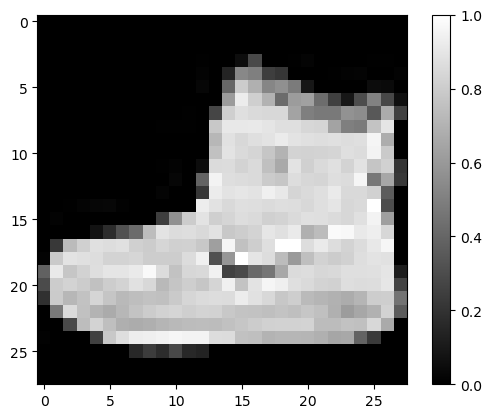

In [13]:
# No information has been lost in the conversion process!
import matplotlib.pyplot as plt
plt.imshow(t.squeeze(), cmap="grey")
plt.colorbar()
None

## Neural Network Model

The model architecture is going to assign to each image input the vector of probability $p_i$ that the item belongs to the $i$th class.
The class prediction is simply the class with the highest probability, but the fact that all $p_i$ are know allows us to evaluate the trust that we should have in the prediction.

The nitty-gritty details:

  - The image should be given as a 28x28 tensor (instead of say a PIL image),

  - The model does actually not output the probabilities $p_i \in [0, 1]$ directly but the corresponding unnormalized log probabilities
    $$
    \ell_i := \log p_i + c
    $$
    Compute $p_i$ with:
    $$
    p_i = \frac{\exp \ell_i}{\sum_{j=0}^{9} \exp \ell_j}.
    $$

    The pytorch [`softmax`](https://pytorch.org/docs/stable/generated/torch.nn.functional.softmax.html) function implements this operation.

In [14]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = torch.nn.Flatten()
        self.linear_1 = torch.nn.Linear(28*28, 512)
        self.relu_1 = torch.nn.ReLU()
        self.linear_2 = torch.nn.Linear(512, 512)
        self.relu_2 = torch.nn.ReLU()
        self.linear_3 = torch.nn.Linear(512, 10)

    def forward(self, image_tensor):
        image_flat = self.flatten(image_tensor)
        x_0 = image_flat
        x_1 = self.linear_1(x_0)
        x_1 = self.relu_1(x_1)
        x_2 = self.linear_2(x_1)
        x_2 = self.relu_2(x_2)
        x_3 = self.linear_3(x_2)
        logits = x_3
        return logits

In [15]:
model = NeuralNetwork()
model

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_1): Linear(in_features=784, out_features=512, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=512, out_features=512, bias=True)
  (relu_2): ReLU()
  (linear_3): Linear(in_features=512, out_features=10, bias=True)
)

In [16]:
# Load the (trained) model state for this architecture
model.load_state_dict(torch.load("models/base-model.pth"))

<All keys matched successfully>

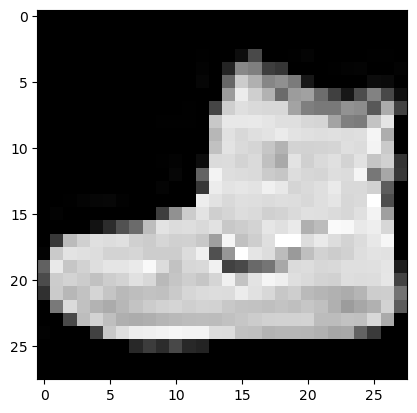

In [17]:
image_tensor, cls = training_data[0]
plt.imshow(image_tensor.squeeze(), cmap="grey")
plt.grid(False)
None

In [18]:
with torch.no_grad():
    logits = model(image_tensor)
logits = logits.squeeze()

In [19]:
probas = torch.nn.functional.softmax(logits, dim=-1)
probas

tensor([1.3868e-06, 1.3274e-07, 1.3592e-05, 4.8298e-06, 3.0793e-05, 1.2058e-01,
        2.0529e-05, 1.3026e-02, 1.7592e-02, 8.4873e-01])

In [20]:
probas_dict = {training_data.classes[i]: p.item() for i, p in enumerate(probas)}
probas_dict = dict(sorted(list(probas_dict.items()), key=lambda pair: -pair[1]))
probas_dict

{'Ankle boot': 0.8487336039543152,
 'Sandal': 0.12057656794786453,
 'Bag': 0.017592474818229675,
 'Sneaker': 0.013026069849729538,
 'Coat': 3.079334055655636e-05,
 'Shirt': 2.0528990717139095e-05,
 'Pullover': 1.3592329196399078e-05,
 'Dress': 4.8297911234840285e-06,
 'T-shirt/top': 1.3868141195416683e-06,
 'Trouser': 1.327381653482007e-07}

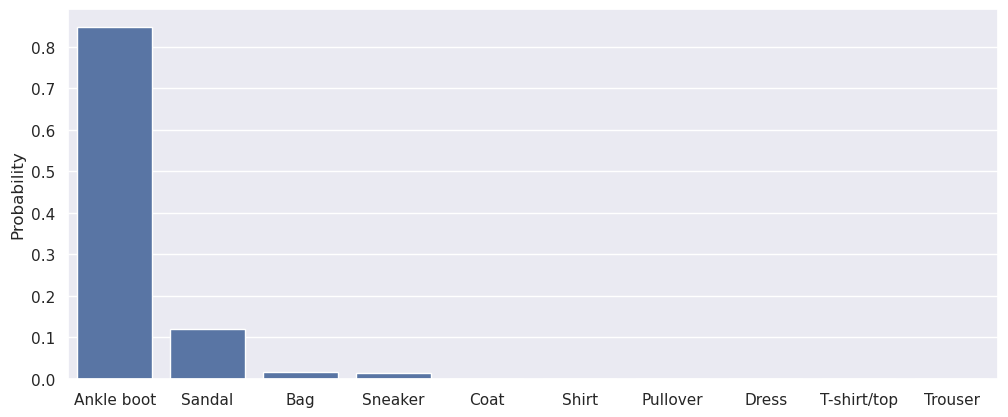

In [21]:
import seaborn as sns; sns.set_theme()
sns.barplot(probas_dict)
plt.gcf().set_figwidth(12)
plt.gca().set_ylabel("Probability")
None

### Parameters

In [22]:
for p in model.parameters():
    print(f"type: {type(p.data).__name__}, shape: {tuple(p.shape)!s:<10}, data type: {p.dtype}")

type: Tensor, shape: (512, 784), data type: torch.float32
type: Tensor, shape: (512,)    , data type: torch.float32
type: Tensor, shape: (512, 512), data type: torch.float32
type: Tensor, shape: (512,)    , data type: torch.float32
type: Tensor, shape: (10, 512) , data type: torch.float32
type: Tensor, shape: (10,)     , data type: torch.float32


```{tip} Model Size
How many scalar parameters describe the model? What is the corresponding model size in MB?
```

In [23]:
num_params = 0
for p in model.parameters():
    num_params += torch.prod(torch.tensor(p.shape)).item()

There are {eval}`num_params` ($\approx$ {eval}`num_params // 1_000`K) parameters in the model. The size of each parameter is 4B, hence the total size is {eval}`round(num_params * 4 / 1_000_000, 1)`MB.

In [24]:
with torch.no_grad():
    to_tensor = torchvision.transforms.ToTensor()
    input = to_tensor(image)
    output = model(input)
output

tensor([[-5.1486, -7.4950, -2.8661, -3.9008, -2.0483,  6.2244, -2.4538,  3.9991,
          4.2996,  8.1759]])

In [25]:
logits = output.data
probas = torch.nn.functional.softmax(logits, dim=-1)
probas = probas.squeeze()
probas

tensor([1.3868e-06, 1.3274e-07, 1.3592e-05, 4.8298e-06, 3.0793e-05, 1.2058e-01,
        2.0529e-05, 1.3026e-02, 1.7592e-02, 8.4873e-01])

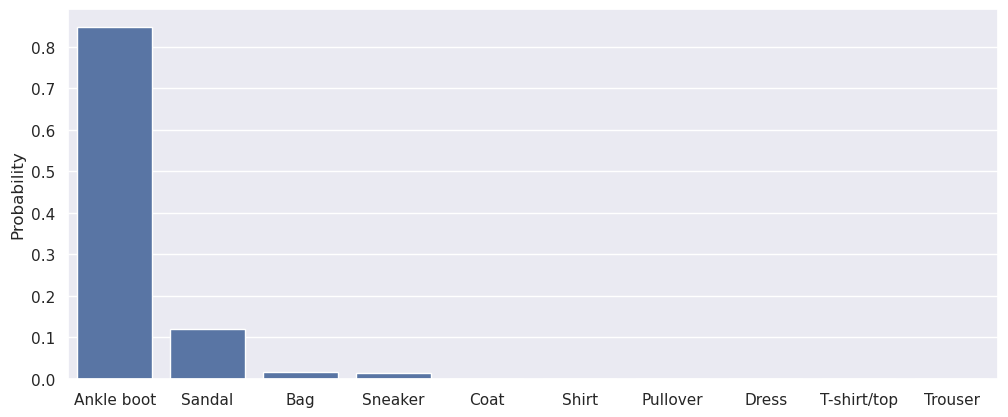

In [26]:
import seaborn as sns; sns.set_theme()
probas_dict = {training_data.classes[i]: p.item() for i, p in enumerate(probas)}
probas_dict = dict(sorted(list(probas_dict.items()), key=lambda pair: -pair[1]))
sns.barplot(probas_dict)
plt.gcf().set_figwidth(12)
plt.gca().set_ylabel("Probability")
None

In [27]:
for key in probas_dict:
    most_likely_category = key
    break
most_likely_category

'Ankle boot'

In [28]:
def prediction(image):
    to_tensor = torchvision.transforms.ToTensor()
    model.eval()
    with torch.no_grad():
        input = to_tensor(image)
        output = model(input)
    logits = output.data.squeeze()
    probas = torch.nn.functional.softmax(logits, dim=-1)
    category_proba = [(training_data.classes[i], p.item()) for i, p in enumerate(probas)]
    category_proba = sorted(category_proba, key=lambda pair: -pair[1])
    return dict(category_proba)

In [29]:
prediction(image)

{'Ankle boot': 0.8487336039543152,
 'Sandal': 0.12057656794786453,
 'Bag': 0.017592474818229675,
 'Sneaker': 0.013026069849729538,
 'Coat': 3.079334055655636e-05,
 'Shirt': 2.0528990717139095e-05,
 'Pullover': 1.3592329196399078e-05,
 'Dress': 4.8297911234840285e-06,
 'T-shirt/top': 1.3868141195416683e-06,
 'Trouser': 1.327381653482007e-07}

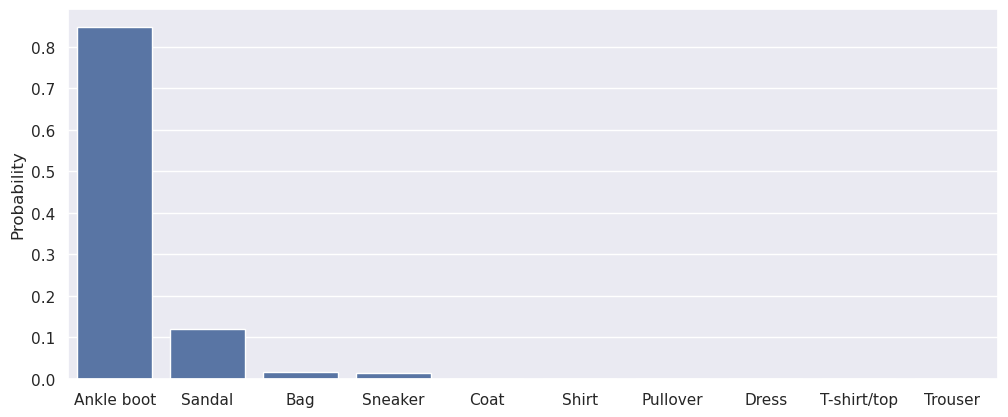

In [30]:
sns.barplot(prediction(image))
plt.gcf().set_figwidth(12)
plt.gca().set_ylabel("Probability")
None

### Under the Hood

In [31]:
model.flatten

Flatten(start_dim=1, end_dim=-1)

In [32]:
image

In [33]:
t = torchvision.transforms.ToTensor()(image)
t

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
          0.2863, 0.0000, 0.0000, 0.0039, 0.0157, 0.0000,

In [34]:
model.flatten(t)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000,
         0.0510, 0.2863, 0.0000, 0.0000, 0.0039, 0.0157, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0039, 0.0

In [35]:
model.linear_1

Linear(in_features=784, out_features=512, bias=True)

In [36]:
model.linear_1.in_features == 28 * 28

True

In [37]:
linear_1_params = {name: param.data for name, param in model.linear_1.named_parameters()}
linear_1_params

{'weight': tensor([[-0.0123, -0.0082, -0.0086,  ...,  0.0301,  0.0236, -0.0208],
         [ 0.0049,  0.0232,  0.0108,  ...,  0.0240,  0.0129, -0.0146],
         [-0.0266, -0.0273, -0.0029,  ..., -0.0252, -0.0186,  0.0080],
         ...,
         [-0.0275, -0.0354,  0.0144,  ..., -0.0323, -0.0247, -0.0268],
         [-0.0043,  0.0089, -0.0103,  ..., -0.0298, -0.0332, -0.0309],
         [ 0.0331, -0.0038,  0.0259,  ...,  0.0354, -0.0015, -0.0210]]),
 'bias': tensor([ 0.0160, -0.0126,  0.0421, -0.0055, -0.0019,  0.0235,  0.0053, -0.0126,
         -0.0015, -0.0334, -0.0011, -0.0298, -0.0034,  0.0076, -0.0143, -0.0093,
          0.0281,  0.0441, -0.0117,  0.0280, -0.0020, -0.0067, -0.0007,  0.0081,
          0.0175,  0.0317,  0.0302,  0.0026,  0.0322, -0.0153, -0.0006, -0.0155,
         -0.0193,  0.0149,  0.0405, -0.0009, -0.0017,  0.0070,  0.0282, -0.0231,
          0.0218,  0.0226,  0.0414,  0.0194,  0.0083, -0.0121,  0.0023,  0.0035,
          0.0056,  0.0430,  0.0312,  0.0286, -0.0175, 

In [38]:
b1 = linear_1_params["bias"]
b1.shape

torch.Size([512])

In [39]:
A1 = linear_1_params["weight"]
A1.shape

torch.Size([512, 784])

In [40]:
to_tensor = torchvision.transforms.ToTensor() 
t = to_tensor(image)
print(t.shape)
tf = torch.flatten(t)
print(tf.shape)
x1 = A1 @ tf + b1
x1

torch.Size([1, 28, 28])
torch.Size([784])


tensor([ 7.5358e-01,  8.9999e-01,  6.3111e-01,  4.8355e-01, -1.6905e-01,
         1.1264e+00,  6.5133e-01,  5.2523e-01,  5.5239e-01,  1.0992e+00,
         6.2707e-02,  1.5292e-01,  7.6799e-02,  1.0851e+00,  1.6657e+00,
        -3.7752e-01,  6.8299e-01,  3.3577e-01,  3.9864e-01,  2.0098e+00,
        -1.5357e-01,  3.1391e-01,  4.7617e-01,  1.7695e+00,  8.6723e-01,
        -3.0988e-01, -4.2693e-01,  1.6203e+00,  2.8783e-01,  7.4779e-01,
         1.6758e-01,  7.0957e-01,  8.9572e-01, -9.4786e-02,  1.6565e+00,
         7.9910e-01,  5.3396e-01, -2.4884e-01,  1.1917e-01,  1.0711e+00,
         6.1352e-01, -3.0341e-01,  3.1174e-01,  4.6290e-01,  7.8370e-02,
        -1.2013e-01,  8.1092e-01,  1.1918e+00, -1.3662e-02,  2.4217e-01,
        -4.3629e-01, -8.0450e-02,  1.9760e-01, -4.1577e-01,  1.6994e+00,
         1.1339e+00,  3.8225e-01,  9.0396e-01,  3.4370e-01, -4.2708e-01,
        -1.2095e-01,  2.6794e-01,  8.0385e-01,  1.0088e+00,  2.2295e-01,
        -1.5955e-01,  1.1572e-01,  7.0667e-01,  2.7

In [41]:
x1 = model.relu_1(x1)
x1

tensor([7.5358e-01, 8.9999e-01, 6.3111e-01, 4.8355e-01, 0.0000e+00, 1.1264e+00,
        6.5133e-01, 5.2523e-01, 5.5239e-01, 1.0992e+00, 6.2707e-02, 1.5292e-01,
        7.6799e-02, 1.0851e+00, 1.6657e+00, 0.0000e+00, 6.8299e-01, 3.3577e-01,
        3.9864e-01, 2.0098e+00, 0.0000e+00, 3.1391e-01, 4.7617e-01, 1.7695e+00,
        8.6723e-01, 0.0000e+00, 0.0000e+00, 1.6203e+00, 2.8783e-01, 7.4779e-01,
        1.6758e-01, 7.0957e-01, 8.9572e-01, 0.0000e+00, 1.6565e+00, 7.9910e-01,
        5.3396e-01, 0.0000e+00, 1.1917e-01, 1.0711e+00, 6.1352e-01, 0.0000e+00,
        3.1174e-01, 4.6290e-01, 7.8370e-02, 0.0000e+00, 8.1092e-01, 1.1918e+00,
        0.0000e+00, 2.4217e-01, 0.0000e+00, 0.0000e+00, 1.9760e-01, 0.0000e+00,
        1.6994e+00, 1.1339e+00, 3.8225e-01, 9.0396e-01, 3.4370e-01, 0.0000e+00,
        0.0000e+00, 2.6794e-01, 8.0385e-01, 1.0088e+00, 2.2295e-01, 0.0000e+00,
        1.1572e-01, 7.0667e-01, 2.7335e-02, 2.5705e-01, 0.0000e+00, 0.0000e+00,
        1.4680e+00, 0.0000e+00, 1.9417e+

In [42]:
list(model.relu_1.named_parameters())

[]

In [43]:
linear_2_params = {name: param.data for name, param in model.linear_2.named_parameters()}
A2 = linear_2_params["weight"]
b2 = linear_2_params["bias"]
x2 = A2 @ x1 + b2
x2

tensor([-5.5644e-01,  2.1868e-01,  1.6277e+00, -1.5260e-01,  3.8835e-01,
        -3.7647e-01,  8.3318e-01,  1.1665e+00,  9.5122e-01, -9.9249e-01,
         6.9296e-01,  4.0299e-01, -5.1219e-01,  4.8513e-01,  1.4259e+00,
        -3.3189e-01,  1.7373e-01,  2.0816e-02,  3.4914e-02, -7.9225e-01,
         9.9839e-01, -3.4624e-01, -3.6851e-01, -3.0848e-01,  1.3827e+00,
        -8.3870e-01,  2.7892e-02, -1.4339e-01,  3.9146e-01, -1.2390e+00,
        -1.4864e-01,  6.1803e-01, -7.4386e-02, -2.3930e-02,  2.8753e+00,
        -1.3853e-01,  1.7234e-01, -4.1123e-02,  2.3155e-01, -1.2290e-01,
        -6.5625e-01,  2.0292e-01,  3.8625e-01,  1.6413e+00, -6.4289e-01,
         2.5722e+00,  3.1687e-01, -8.5471e-01, -1.6177e-01, -7.8311e-01,
        -5.3492e-01, -5.9756e-01,  2.0177e-01,  1.5403e+00,  9.6946e-01,
         1.8036e+00,  2.7096e-01, -2.9942e-01,  7.8801e-01,  1.6924e+00,
        -4.9962e-01, -5.6837e-01,  9.6208e-01,  5.8110e-01,  6.4326e-01,
        -3.0944e-01,  2.7237e+00,  2.7676e-01,  3.7

In [44]:
x2 = model.relu_2(x2)
x2

tensor([0.0000e+00, 2.1868e-01, 1.6277e+00, 0.0000e+00, 3.8835e-01, 0.0000e+00,
        8.3318e-01, 1.1665e+00, 9.5122e-01, 0.0000e+00, 6.9296e-01, 4.0299e-01,
        0.0000e+00, 4.8513e-01, 1.4259e+00, 0.0000e+00, 1.7373e-01, 2.0816e-02,
        3.4914e-02, 0.0000e+00, 9.9839e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.3827e+00, 0.0000e+00, 2.7892e-02, 0.0000e+00, 3.9146e-01, 0.0000e+00,
        0.0000e+00, 6.1803e-01, 0.0000e+00, 0.0000e+00, 2.8753e+00, 0.0000e+00,
        1.7234e-01, 0.0000e+00, 2.3155e-01, 0.0000e+00, 0.0000e+00, 2.0292e-01,
        3.8625e-01, 1.6413e+00, 0.0000e+00, 2.5722e+00, 3.1687e-01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0177e-01, 1.5403e+00,
        9.6946e-01, 1.8036e+00, 2.7096e-01, 0.0000e+00, 7.8801e-01, 1.6924e+00,
        0.0000e+00, 0.0000e+00, 9.6208e-01, 5.8110e-01, 6.4326e-01, 0.0000e+00,
        2.7237e+00, 2.7676e-01, 3.7707e-01, 2.2630e+00, 7.8509e-01, 0.0000e+00,
        1.8902e+00, 8.5285e-01, 0.0000e+

In [45]:
linear_3_params = {name: param.data for name, param in model.linear_3.named_parameters()}
A3 = linear_3_params["weight"]
b3 = linear_3_params["bias"]
x3 = A3 @ x2 + b3
x3

tensor([-5.1486, -7.4950, -2.8661, -3.9008, -2.0483,  6.2244, -2.4538,  3.9991,
         4.2996,  8.1759])

In [46]:
def softmax(x):
    return torch.nn.functional.softmax(x, dim=0)

probas = softmax(x3)
probas

tensor([1.3868e-06, 1.3274e-07, 1.3592e-05, 4.8298e-06, 3.0793e-05, 1.2058e-01,
        2.0529e-05, 1.3026e-02, 1.7592e-02, 8.4873e-01])

In [47]:
data = {training_data.classes[i]: p.item() for i, p in enumerate(probas)}
data

{'T-shirt/top': 1.3868141195416683e-06,
 'Trouser': 1.327381653482007e-07,
 'Pullover': 1.3592329196399078e-05,
 'Dress': 4.8297911234840285e-06,
 'Coat': 3.079334055655636e-05,
 'Sandal': 0.12057656794786453,
 'Shirt': 2.0528990717139095e-05,
 'Sneaker': 0.013026069849729538,
 'Bag': 0.017592474818229675,
 'Ankle boot': 0.8487336039543152}

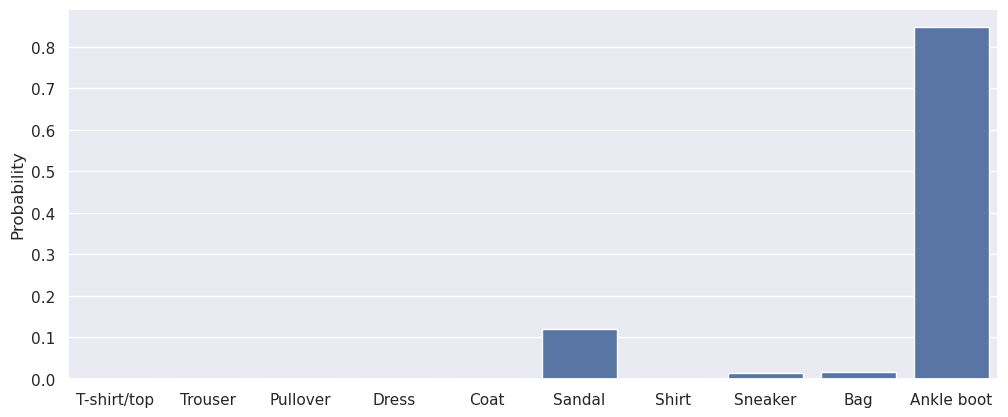

In [48]:
import seaborn as sns; sns.set_theme()
sns.barplot(data)
plt.gcf().set_figwidth(12)
plt.gca().set_ylabel("Probability")
None

In [49]:
out = model(t).data.squeeze()

In [50]:
ps = torch.nn.functional.softmax(out, dim=-1)

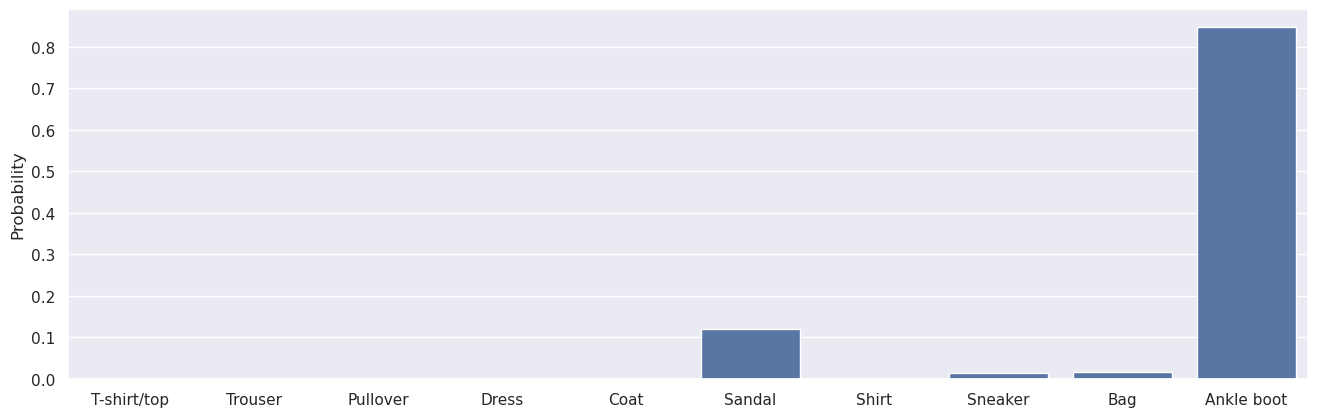

In [51]:
data = {training_data.classes[i]: p.item() for i, p in enumerate(ps)}
sns.barplot(data)
plt.gcf().set_figwidth(16)
plt.gca().set_ylabel("Probability")
None

## Training

### Loss Function

The loss function is a measure of the model prediction error: the mismatch between the output predicted by the model and the "real" output. Here, in the context of category identification, we use the cross-entropy loss function.

In [52]:
loss_function = torch.nn.CrossEntropyLoss()

It measures the differences between two probability distributions: here a computed probability distribution $p=(p_0, \dots, p_{n-1})$ and a "deterministic" distribution $q=e_i$ with
$$
e_i=(0, \dots, 0, 1, 0, \dots, 0) \;\;\; \mbox{($1$ in position $i$)}
$$
with:
$$
\mathrm{loss}(p, e_i) = - \log p_i. 
$$
The loss is zero when $p_i = 1$ (perfect match) and $-\infty$ when $p_i = 0$. It does not depend on the distribution of the $p_j$ for $j \neq i$.

```{warning}
The pytorch cross entropy function works directly with unnormalized log probabilities 
$$
\ell_i := \log p_i + c
$$
(the log probabilities up to a shared constant $c$) instead of the probabilites $p$. 
The deterministic distribution is also specified by the index $i$ instead of the vector $q=e_i$.
Hence, it actually computes
$$
\mathrm{loss}(\ell, i) := -\ell_i  + \log \left( \sum_je^{\ell_j} \right). 
$$
```


In [53]:
cross_entropy = torch.nn.CrossEntropyLoss()

In [54]:
cross_entropy(
    input=torch.tensor([1.0, 0.0]).log(), 
    target=torch.tensor(0)
)

tensor(0.)

In [55]:
cross_entropy(
    input=torch.tensor([0.0, 1.0]).log(), 
    target=torch.tensor(0)
)

tensor(inf)

In [56]:
cross_entropy(
    input=torch.tensor([0.5, 0.5]).log(), 
    target=torch.tensor(0)
)

tensor(0.6931)

In [57]:
- torch.tensor(0.5).log()

tensor(0.6931)

In [58]:
cross_entropy(
    input=torch.tensor([2/3, 1/3]).log(), 
    target=torch.tensor(0)
)

tensor(0.4055)

In [59]:
cross_entropy(
    input=torch.tensor([200.0, 100.0]).log(), 
    target=torch.tensor(0)
)

tensor(0.4055)

### Data Loader

In [60]:
batch_size = 64

# Create data loaders.
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"X = [N, C, H, W]: {X.shape}")
    print(f"y: {y.shape} {y.dtype}")
    break

X = [N, C, H, W]: torch.Size([64, 1, 28, 28])
y: torch.Size([64]) torch.int64


In [61]:
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

### Training

In [62]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [63]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [64]:
def test(dataloader, model, loss_fn):
    """
    Returns:
      - score, the probability of a correct inference on the test dataset
    """
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.2f}%, Avg loss: {test_loss:>8f} \n")
    return correct

```{error}
Training buggy ATM! Recent changes (in cross-entropy section) have caused that?
```

In [65]:
model = NeuralNetwork()

loss_function = torch.nn.CrossEntropyLoss()

score = 0.0
new_score = test(test_dataloader, model, loss_function)
epoch = 0
keep_learning = True
while keep_learning:
    epoch += 1
    score = new_score
    print(f"Epoch {epoch+1}\n-------------------------------")
    train(train_dataloader, model, loss_function, optimizer)
    new_score = test(test_dataloader, model, loss_function)
    keep_learning = new_score > score

print("Done!")


Test Error: 
 Accuracy: 10.03%, Avg loss: 2.307566 

Epoch 2
-------------------------------
loss: 2.305667  [   64/60000]
loss: 2.309455  [ 6464/60000]
loss: 2.311952  [12864/60000]
loss: 2.308064  [19264/60000]
loss: 2.311566  [25664/60000]
loss: 2.302675  [32064/60000]
loss: 2.313544  [38464/60000]
loss: 2.308548  [44864/60000]
loss: 2.299366  [51264/60000]
loss: 2.305454  [57664/60000]
Test Error: 
 Accuracy: 10.03%, Avg loss: 2.307566 

Done!


In [66]:
torch.save(model.state_dict(), "models/model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


## Use the Model

In [67]:
model = NeuralNetwork()
model.load_state_dict(torch.load("models/model.pth"))

<All keys matched successfully>

In [68]:
classes = test_data.classes

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Coat", Actual: "Ankle boot"


Known category: Ankle boot
Predicted category: Coat


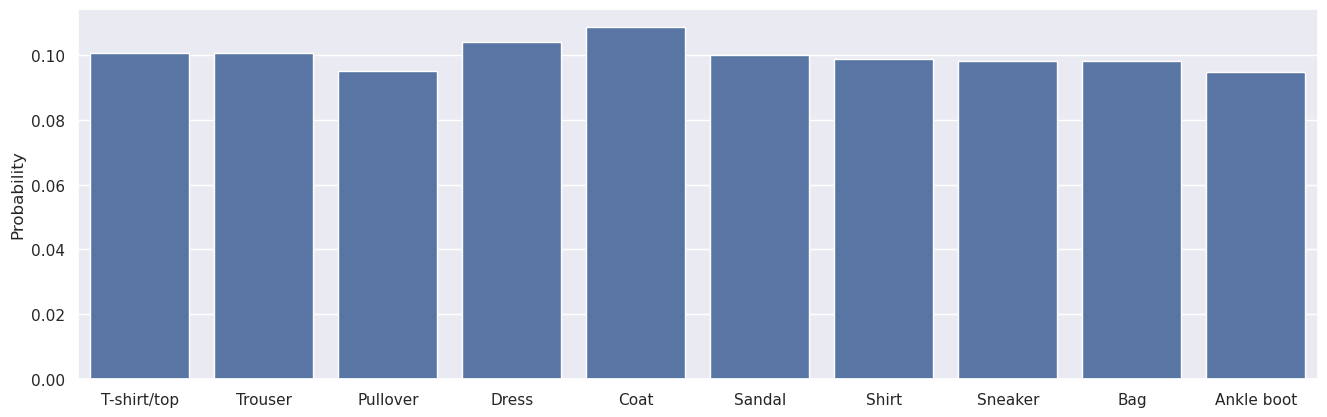

In [69]:
model.eval()
input, output = test_data[0][0], test_data[0][1]
print(f"Known category: {test_data.classes[output]}")
logits = model(input)
logits = logits.data.squeeze()
probas = torch.nn.functional.softmax(logits, dim=-1)
print(f"Predicted category: {test_data.classes[probas.argmax().item()]}")
data = {training_data.classes[i]: p.item() for i, p in enumerate(probas)}
sns.barplot(data)
plt.gcf().set_figwidth(16)
plt.gca().set_ylabel("Probability")
None